In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import shap
import joblib


In [23]:
columns = [
    'ID','LIMIT_BAL','SEX','EDUCATION','MARRIAGE','AGE',
    'PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6',
    'BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6',
    'PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6',
    'TARGET'
]


In [24]:
df = pd.read_csv('/kaggle/input/default-of-credit-card-clients-dataset/UCI_Credit_Card.csv', header=1)

# Display basic info
print(df.shape)
print(df.head())
print(df.info())
print(df.describe())


(29999, 25)
   1     20000  2  2.1  1.1  24  2.2  2.3  -1  -1.1  ...        0      0.1  \
0  2  120000.0  2    2    2  26   -1    2   0     0  ...   3272.0   3455.0   
1  3   90000.0  2    2    2  34    0    0   0     0  ...  14331.0  14948.0   
2  4   50000.0  2    2    1  37    0    0   0     0  ...  28314.0  28959.0   
3  5   50000.0  1    2    1  57   -1    0  -1     0  ...  20940.0  19146.0   
4  6   50000.0  1    1    2  37    0    0   0     0  ...  19394.0  19619.0   

       0.2     0.3    689.1      0.4     0.5     0.6     0.7  1.2  
0   3261.0     0.0   1000.0   1000.0  1000.0     0.0  2000.0    1  
1  15549.0  1518.0   1500.0   1000.0  1000.0  1000.0  5000.0    0  
2  29547.0  2000.0   2019.0   1200.0  1100.0  1069.0  1000.0    0  
3  19131.0  2000.0  36681.0  10000.0  9000.0   689.0   679.0    0  
4  20024.0  2500.0   1815.0    657.0  1000.0  1000.0   800.0    0  

[5 rows x 25 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29999 entries, 0 to 29998
Data columns

In [25]:
# Assign correct column names
df.columns = columns

# Check
print(df.head())
print(df.columns)

   ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   2   120000.0    2          2         2   26     -1      2      0      0   
1   3    90000.0    2          2         2   34      0      0      0      0   
2   4    50000.0    2          2         1   37      0      0      0      0   
3   5    50000.0    1          2         1   57     -1      0     -1      0   
4   6    50000.0    1          1         2   37      0      0      0      0   

   ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0  ...     3272.0     3455.0     3261.0       0.0    1000.0    1000.0   
1  ...    14331.0    14948.0    15549.0    1518.0    1500.0    1000.0   
2  ...    28314.0    28959.0    29547.0    2000.0    2019.0    1200.0   
3  ...    20940.0    19146.0    19131.0    2000.0   36681.0   10000.0   
4  ...    19394.0    19619.0    20024.0    2500.0    1815.0     657.0   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  TARGET  
0    1000.0       0.0    2000.0       1  
1 

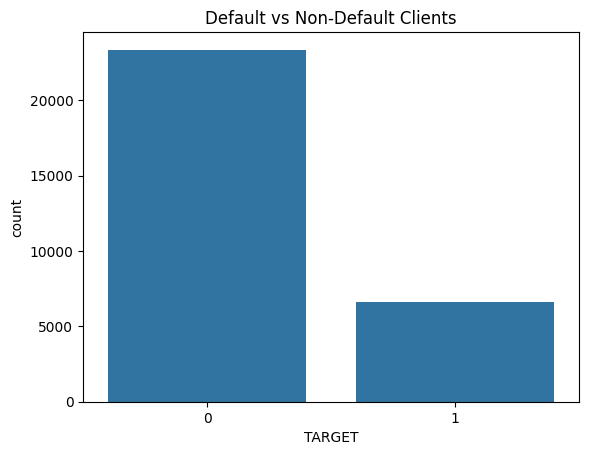

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='TARGET', data=df)
plt.title('Default vs Non-Default Clients')
plt.show()

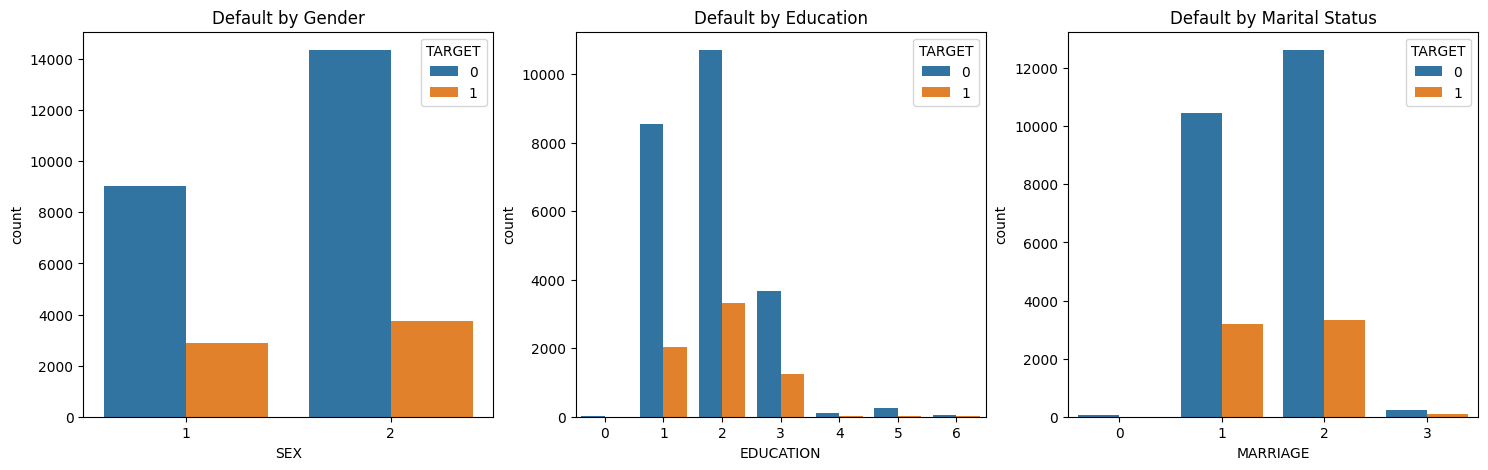

In [27]:
fig, axes = plt.subplots(1,3, figsize=(18,5))

sns.countplot(x='SEX', hue='TARGET', data=df, ax=axes[0])
axes[0].set_title('Default by Gender')

sns.countplot(x='EDUCATION', hue='TARGET', data=df, ax=axes[1])
axes[1].set_title('Default by Education')

sns.countplot(x='MARRIAGE', hue='TARGET', data=df, ax=axes[2])
axes[2].set_title('Default by Marital Status')

plt.show()


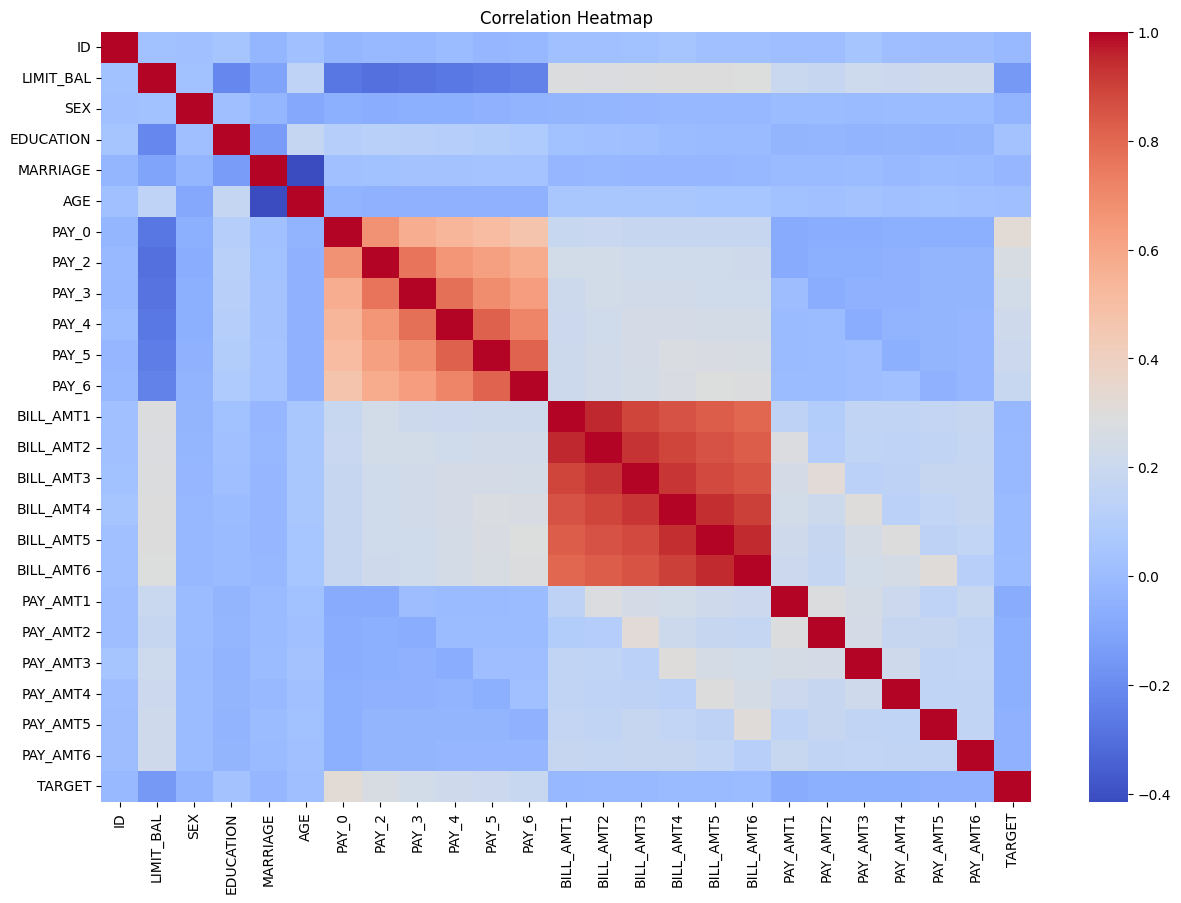

In [28]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [29]:
df['SEX'] = df['SEX'].astype('category')
df['EDUCATION'] = df['EDUCATION'].astype('category')
df['MARRIAGE'] = df['MARRIAGE'].astype('category')


In [30]:
X = df.drop(['ID', 'TARGET'], axis=1)
y = df['TARGET']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [31]:
cat_cols = ['SEX','EDUCATION','MARRIAGE']
X_train = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=cat_cols, drop_first=True)


In [32]:
num_cols = X.select_dtypes(include=['int64','float64']).columns
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)


In [33]:
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=500, max_depth=10, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=500, max_depth=5, learning_rate=0.05, use_label_encoder=False, eval_metric='logloss', random_state=42)
}

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    print(f'{name} ROC-AUC: {scores.mean():.4f}')


Logistic Regression ROC-AUC: 0.7254
Random Forest ROC-AUC: 0.7825


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [20:27:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [20:27:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [20:27:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [20:27:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [20:27:21] WARNING: /w

XGBoost ROC-AUC: 0.7779


In [35]:
param_grid = {
    'max_depth': [3,5,7],
    'learning_rate': [0.01,0.05,0.1],
    'n_estimators': [100,300,500],
    'subsample': [0.8,1],
    'colsample_bytree': [0.8,1]
}

grid = GridSearchCV(XGBClassifier( eval_metric='logloss', random_state=42),
                    param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
print('Best Parameters:', grid.best_params_)


Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}


              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.66      0.37      0.47      1327

    accuracy                           0.82      6000
   macro avg       0.75      0.66      0.68      6000
weighted avg       0.80      0.82      0.80      6000

ROC-AUC: 0.7773


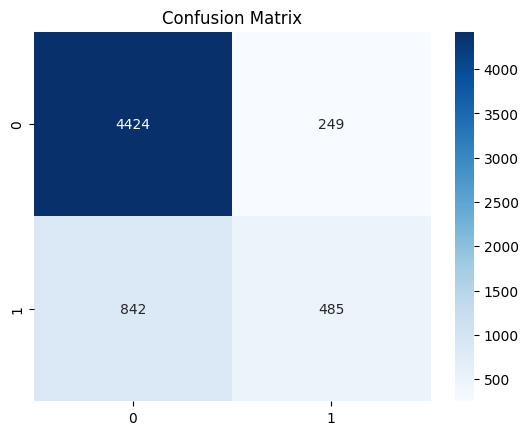

In [36]:
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print(f'ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}')

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
joblib.dump(best_model, 'credit_scoring_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
